Ссылка на репо: [https://github.com/HuviX/onnxvstorch](https://github.com/HuviX/onnxvstorch)

Написан сервис, который содержит в себе две одинаковые [модели](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) для определения тональности текста:
- pyTorch версия модели
- ONNX версия модели (получена из pytorch)

Используя две разные версии Runtime сравним скорость обработки ответа.

Сервис синхронный, RestAPI (Flask Based)

Пример запроса

In [1]:
!curl -X POST http://127.0.0.1:5000/predict_torch \
   -H 'Content-Type: application/json' \
   -d '{"data": "Food was terrible"}'
        
!curl -X POST http://127.0.0.1:5000/predict_onnx \
   -H 'Content-Type: application/json' \
   -d '{"data": "Food was terrible"}'

{"response":"OK","response_body":{"negative":"0.9753498","neutral":"0.021798257","positive":"0.0028519912"},"time_spent":"0.044941281026694924"}
{"response":"OK","response_body":{"negative":"0.9753498","neutral":"0.02179822","positive":"0.002851987"},"time_spent":"0.024621349992230535"}


Сделаем несколько сотен запросов к сервису, чтобы оценить время работы модели. Запросы будем делать 2req/s, чтобы не нагружать канал.

In [2]:
from typing import Dict, List

import json
from matplotlib import pyplot as plt
import numpy as np
import requests
import time

from tqdm import tqdm


def make_test(amount_of_requests: int, sleep_time: float, handle: str, data: Dict[str, str]) -> List[str]:
    times = []
    for _ in tqdm(range(amount_of_requests)):
        resp = requests.post(handle, json=data)
        resp = json.loads(resp.text)
        times.append(float(resp["time_spent"]))
        time.sleep(sleep_time)
    return times

def plot_results(result_onnx, result_torch):
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(range(len(result_onnx)), result_onnx, label="onnx inference time")
    ax.scatter(range(len(result_onnx)), result_torch, label="pyTorch inference time")
    ax.set_title("Inference time (ms) per runtime type")
    ax.set_ylabel("Inference time (ms)")
    ax.legend()
    ax.grid()
    ####
    fig.show()
    
    results = {}
    results["torch"] = result_torch
    results["onnx"] = result_onnx
    time_results = {k: np.mean(v) * 1000 for k, v in results.items()}
    time_results_std = np.std([v for v in results.values()]) * 1000
    
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_ylabel("Avg Inference time (ms)")
    ax.set_title("Average inference time (ms)")
    ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
    plt.show()

100%|█████████████████████████████████████████| 100/100 [01:00<00:00,  1.67it/s]
/tmp/ipykernel_163255/4060151414.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


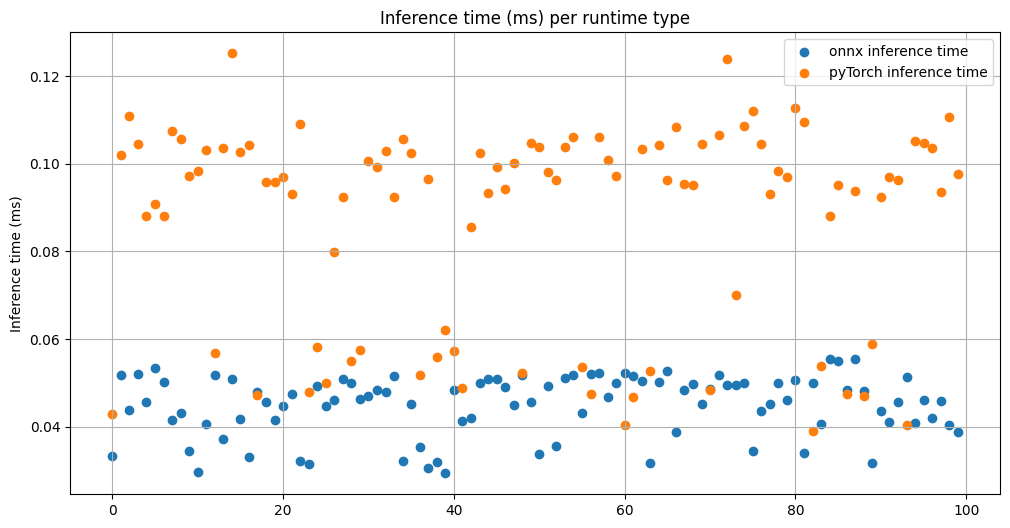

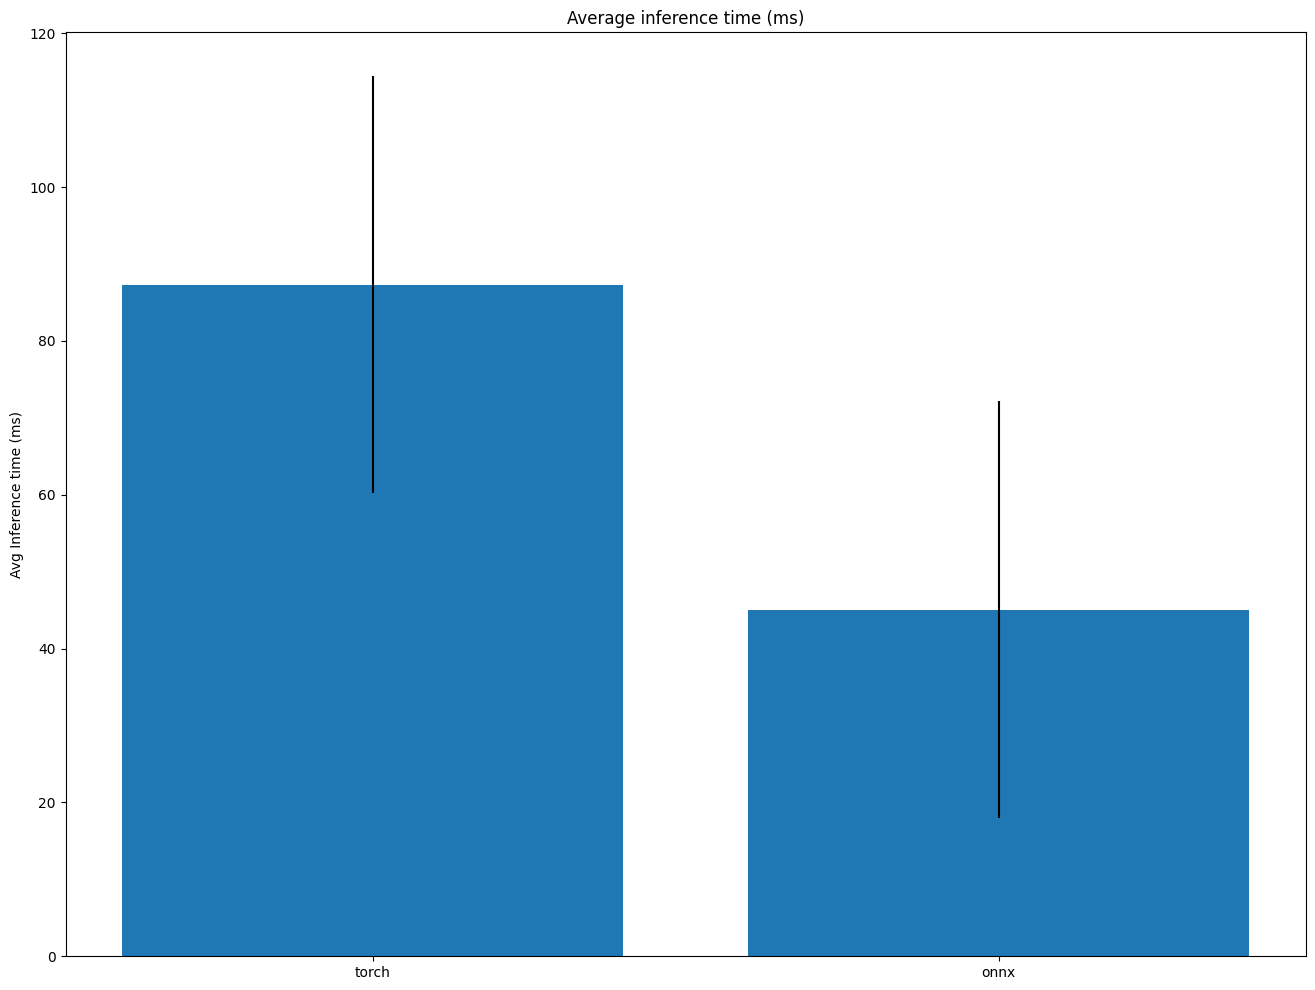

In [3]:
amount_of_requests = 100
sleep_time = 0.5
data = {"data": "Food was terrible"}
result_onnx = make_test(
    amount_of_requests=amount_of_requests,
    sleep_time=sleep_time,
    data=data,
    handle="http://127.0.0.1:5000/predict_onnx",
)
result_torch = make_test(
    amount_of_requests=amount_of_requests,
    sleep_time=sleep_time,
    data=data,
    handle="http://127.0.0.1:5000/predict_torch",
)
plot_results(result_onnx, result_torch)

Сделаем такой же самый тест, но теперь для текста большего размера.

100%|█████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]
/tmp/ipykernel_163255/4060151414.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


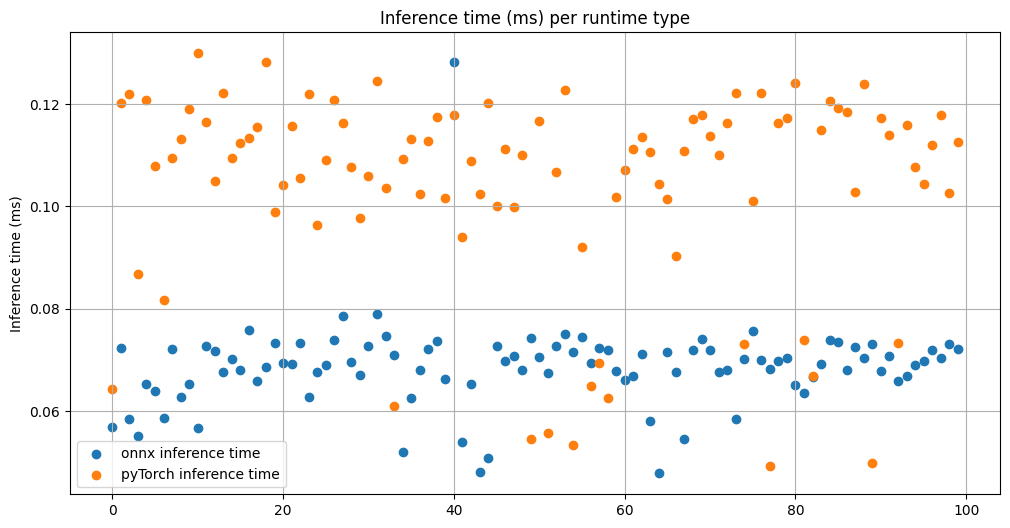

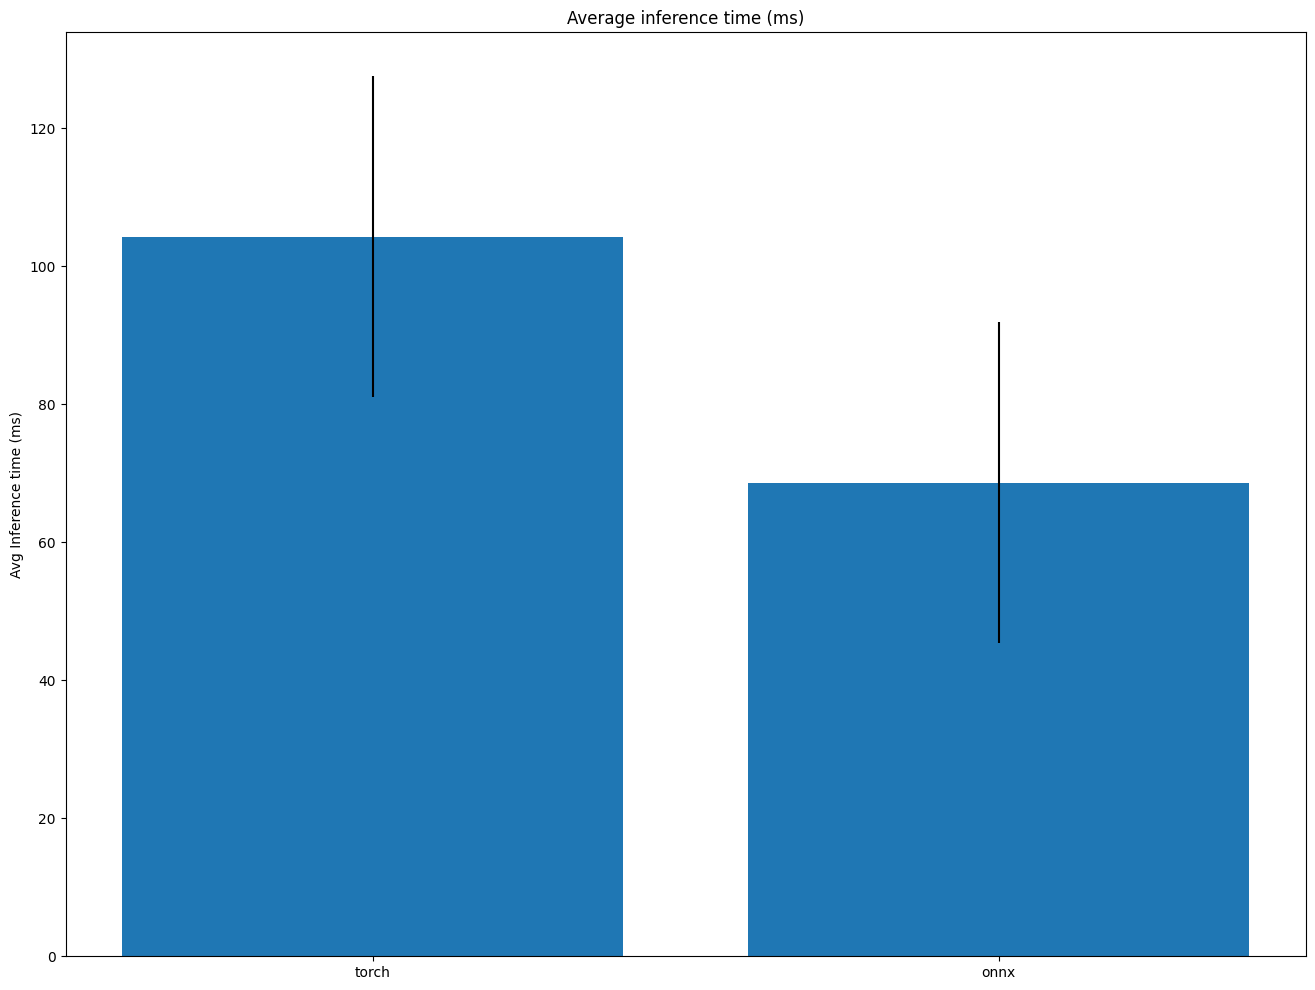

In [4]:
amount_of_requests = 100
sleep_time = 0.5
data = {"data": "Food was terrible but I liked the interior there really much"}
result_onnx = make_test(
    amount_of_requests=amount_of_requests,
    sleep_time=sleep_time,
    data=data,
    handle="http://127.0.0.1:5000/predict_onnx",
)
result_torch = make_test(
    amount_of_requests=amount_of_requests,
    sleep_time=sleep_time,
    data=data,
    handle="http://127.0.0.1:5000/predict_torch",
)
plot_results(result_onnx, result_torch)

По графикам и рисункам видно, что конвертация модели в ONNX позволяет выполнять Inference быстрее.

На данный момент ONNX является промежуточным звеном для pytorch моделей перед реальным деплоем в Production окружение. Для инференса на GPU стоит рассмотреть Nvidia Triton Inference Server, а для CPU машин на базе процессоров Intel хорошим решением является OpenVino Runtime. Но даже без hardware specific оптимизаций можно получить значимое усорение с помощью перевода из Torch в ONNX.